##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 4292608/13568290 [========>.....................] - ETA: 0s

 9396224/13568290 [===================>..........] - ETA: 0s

13574144/13568290 [==============================] - 0s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [4]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

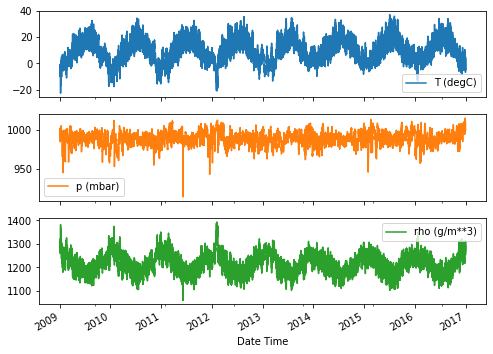

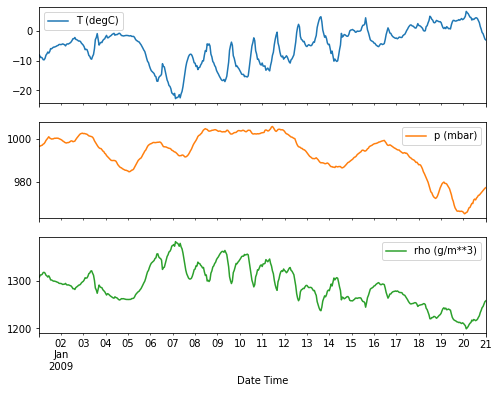

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

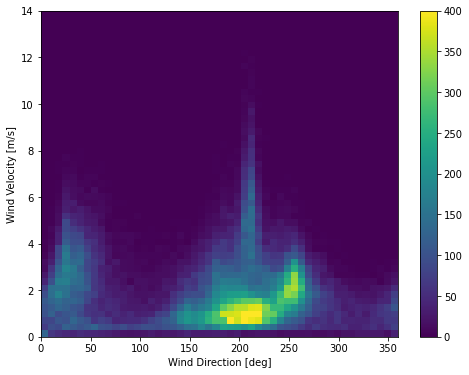

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

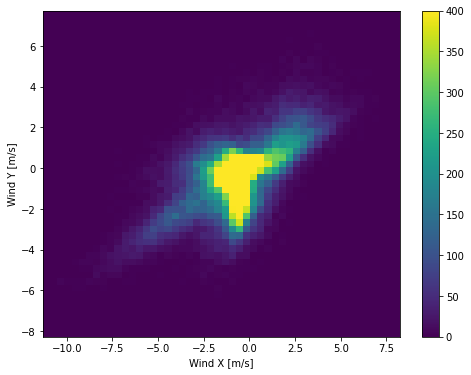

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [12]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

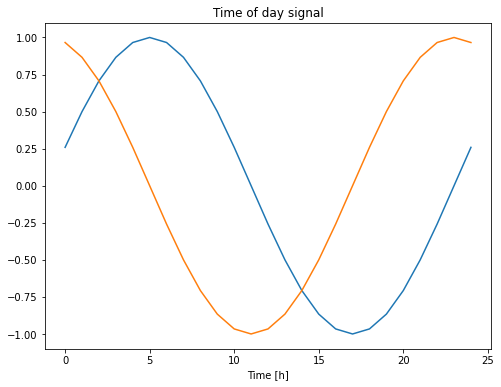

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

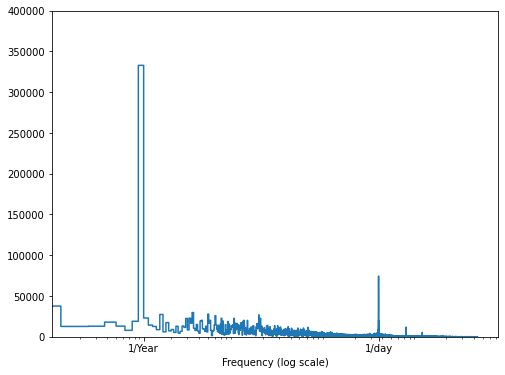

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

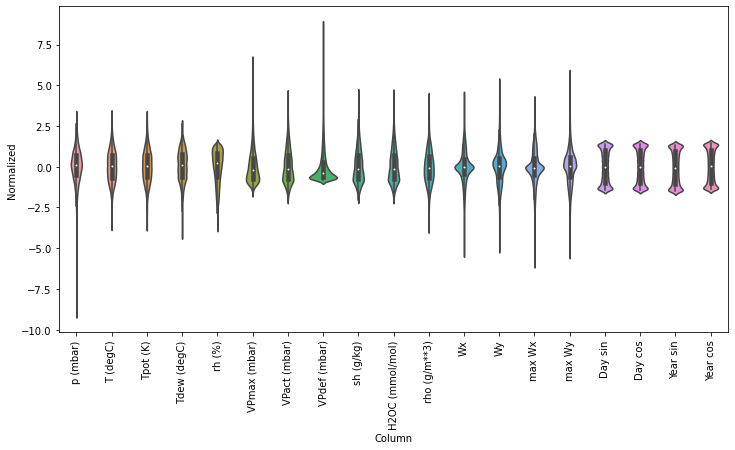

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](images/raw_window_24h.png)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [23]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

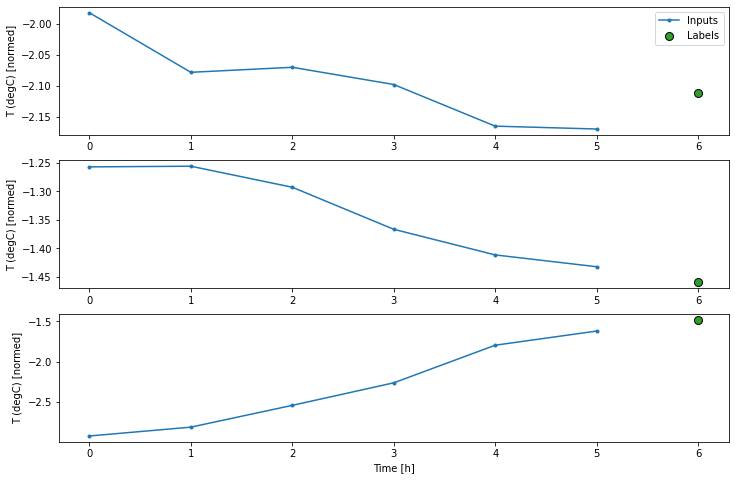

In [26]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

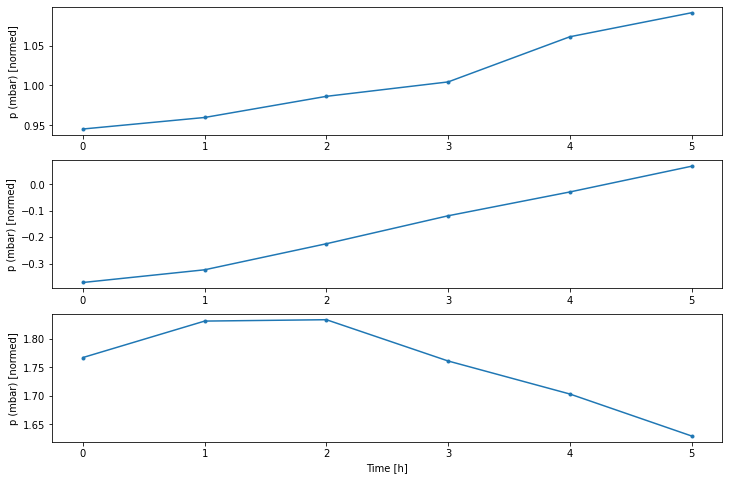

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `T (degC)` value 1h into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 1:12 - loss: 0.0123 - mean_absolute_error: 0.0864

 33/439 [=>............................] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0802  

 69/439 [===>..........................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0785

103/439 [======>.......................] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0776

138/439 [========>.....................] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0777

173/439 [==========>...................] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0781

209/439 [=============>................] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0788

245/439 [===============>..............] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

280/439 [==================>...........] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0783

315/439 [====================>.........] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

352/439 [=======================>......] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0785

386/439 [=========================>....] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0786

420/439 [===========================>..] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

439/439 [==============================] - 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

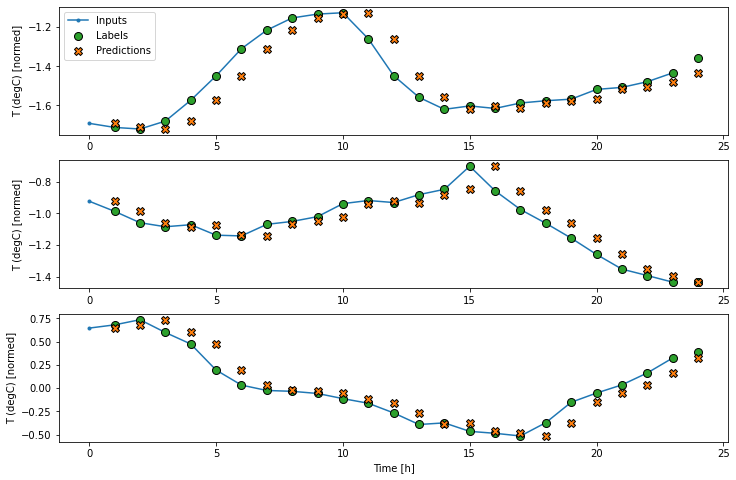

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explanation:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 7:47 - loss: 7.1734 - mean_absolute_error: 2.2103

  25/1534 [..............................] - ETA: 3s - loss: 4.6797 - mean_absolute_error: 1.7277  

  50/1534 [..............................] - ETA: 3s - loss: 4.1222 - mean_absolute_error: 1.6195

  73/1534 [>.............................] - ETA: 3s - loss: 3.6802 - mean_absolute_error: 1.5127

  97/1534 [>.............................] - ETA: 3s - loss: 3.3551 - mean_absolute_error: 1.4360

 121/1534 [=>............................] - ETA: 2s - loss: 3.0390 - mean_absolute_error: 1.3586

 145/1534 [=>............................] - ETA: 2s - loss: 2.7662 - mean_absolute_error: 1.2853

 169/1534 [==>...........................] - ETA: 2s - loss: 2.5390 - mean_absolute_error: 1.2232

 193/1534 [==>...........................] - ETA: 2s - loss: 2.3207 - mean_absolute_error: 1.1574

 217/1534 [===>..........................] - ETA: 2s - loss: 2.1422 - mean_absolute_error: 1.1028

 240/1534 [===>..........................] - ETA: 2s - loss: 1.9920 - mean_absolute_error: 1.0532

 262/1534 [====>.........................] - ETA: 2s - loss: 1.8630 - mean_absolute_error: 1.0100

 285/1534 [====>.........................] - ETA: 2s - loss: 1.7405 - mean_absolute_error: 0.9659

 309/1534 [=====>........................] - ETA: 2s - loss: 1.6322 - mean_absolute_error: 0.9271

 333/1534 [=====>........................] - ETA: 2s - loss: 1.5359 - mean_absolute_error: 0.8908

 358/1534 [======>.......................] - ETA: 2s - loss: 1.4450 - mean_absolute_error: 0.8556

 382/1534 [======>.......................] - ETA: 2s - loss: 1.3680 - mean_absolute_error: 0.8248

 406/1534 [======>.......................] - ETA: 2s - loss: 1.2986 - mean_absolute_error: 0.7971

 430/1534 [=======>......................] - ETA: 2s - loss: 1.2351 - mean_absolute_error: 0.7700

 454/1534 [=======>......................] - ETA: 2s - loss: 1.1774 - mean_absolute_error: 0.7449

 477/1534 [========>.....................] - ETA: 2s - loss: 1.1271 - mean_absolute_error: 0.7227

 501/1534 [========>.....................] - ETA: 2s - loss: 1.0787 - mean_absolute_error: 0.7009

 525/1534 [=========>....................] - ETA: 2s - loss: 1.0348 - mean_absolute_error: 0.6812

 549/1534 [=========>....................] - ETA: 2s - loss: 0.9941 - mean_absolute_error: 0.6625

 573/1534 [==========>...................] - ETA: 2s - loss: 0.9567 - mean_absolute_error: 0.6452

 597/1534 [==========>...................] - ETA: 1s - loss: 0.9213 - mean_absolute_error: 0.6281

 621/1534 [===========>..................] - ETA: 1s - loss: 0.8888 - mean_absolute_error: 0.6123

 645/1534 [===========>..................] - ETA: 1s - loss: 0.8586 - mean_absolute_error: 0.5973

 669/1534 [============>.................] - ETA: 1s - loss: 0.8308 - mean_absolute_error: 0.5838

 693/1534 [============>.................] - ETA: 1s - loss: 0.8043 - mean_absolute_error: 0.5704

 718/1534 [=============>................] - ETA: 1s - loss: 0.7788 - mean_absolute_error: 0.5576

 742/1534 [=============>................] - ETA: 1s - loss: 0.7555 - mean_absolute_error: 0.5455

 765/1534 [=============>................] - ETA: 1s - loss: 0.7348 - mean_absolute_error: 0.5350

 789/1534 [==============>...............] - ETA: 1s - loss: 0.7142 - mean_absolute_error: 0.5242

 813/1534 [==============>...............] - ETA: 1s - loss: 0.6948 - mean_absolute_error: 0.5140

 836/1534 [===============>..............] - ETA: 1s - loss: 0.6773 - mean_absolute_error: 0.5047

 859/1534 [===============>..............] - ETA: 1s - loss: 0.6605 - mean_absolute_error: 0.4958

 880/1534 [================>.............] - ETA: 1s - loss: 0.6461 - mean_absolute_error: 0.4883

 903/1534 [================>.............] - ETA: 1s - loss: 0.6310 - mean_absolute_error: 0.4802

 927/1534 [=================>............] - ETA: 1s - loss: 0.6160 - mean_absolute_error: 0.4721

 951/1534 [=================>............] - ETA: 1s - loss: 0.6018 - mean_absolute_error: 0.4643

 976/1534 [==================>...........] - ETA: 1s - loss: 0.5877 - mean_absolute_error: 0.4567

1000/1534 [==================>...........] - ETA: 1s - loss: 0.5747 - mean_absolute_error: 0.4497

1024/1534 [===================>..........] - ETA: 1s - loss: 0.5624 - mean_absolute_error: 0.4431

1048/1534 [===================>..........] - ETA: 1s - loss: 0.5505 - mean_absolute_error: 0.4365

1072/1534 [===================>..........] - ETA: 0s - loss: 0.5391 - mean_absolute_error: 0.4301

1095/1534 [====================>.........] - ETA: 0s - loss: 0.5286 - mean_absolute_error: 0.4243

1119/1534 [====================>.........] - ETA: 0s - loss: 0.5182 - mean_absolute_error: 0.4184

1143/1534 [=====================>........] - ETA: 0s - loss: 0.5083 - mean_absolute_error: 0.4130

1166/1534 [=====================>........] - ETA: 0s - loss: 0.4991 - mean_absolute_error: 0.4079

1190/1534 [======================>.......] - ETA: 0s - loss: 0.4899 - mean_absolute_error: 0.4027

1215/1534 [======================>.......] - ETA: 0s - loss: 0.4808 - mean_absolute_error: 0.3977

1239/1534 [=======================>......] - ETA: 0s - loss: 0.4722 - mean_absolute_error: 0.3928

1262/1534 [=======================>......] - ETA: 0s - loss: 0.4643 - mean_absolute_error: 0.3884

1286/1534 [========================>.....] - ETA: 0s - loss: 0.4564 - mean_absolute_error: 0.3838

1310/1534 [========================>.....] - ETA: 0s - loss: 0.4487 - mean_absolute_error: 0.3795

1333/1534 [=========================>....] - ETA: 0s - loss: 0.4416 - mean_absolute_error: 0.3755

1357/1534 [=========================>....] - ETA: 0s - loss: 0.4345 - mean_absolute_error: 0.3714

1381/1534 [==========================>...] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.3675

1405/1534 [==========================>...] - ETA: 0s - loss: 0.4209 - mean_absolute_error: 0.3635

1429/1534 [==========================>...] - ETA: 0s - loss: 0.4144 - mean_absolute_error: 0.3597

1453/1534 [===========================>..] - ETA: 0s - loss: 0.4082 - mean_absolute_error: 0.3561

1477/1534 [===========================>..] - ETA: 0s - loss: 0.4021 - mean_absolute_error: 0.3526

1501/1534 [============================>.] - ETA: 0s - loss: 0.3963 - mean_absolute_error: 0.3493

1526/1534 [============================>.] - ETA: 0s - loss: 0.3903 - mean_absolute_error: 0.3458

1534/1534 [==============================] - 4s 3ms/step - loss: 0.3887 - mean_absolute_error: 0.3448 - val_loss: 0.0281 - val_mean_absolute_error: 0.1269


Epoch 2/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0314 - mean_absolute_error: 0.1375

  25/1534 [..............................] - ETA: 3s - loss: 0.0302 - mean_absolute_error: 0.1330 

  50/1534 [..............................] - ETA: 3s - loss: 0.0325 - mean_absolute_error: 0.1351

  75/1534 [>.............................] - ETA: 3s - loss: 0.0318 - mean_absolute_error: 0.1341

  99/1534 [>.............................] - ETA: 3s - loss: 0.0315 - mean_absolute_error: 0.1338

 124/1534 [=>............................] - ETA: 2s - loss: 0.0316 - mean_absolute_error: 0.1340

 149/1534 [=>............................] - ETA: 2s - loss: 0.0320 - mean_absolute_error: 0.1342

 173/1534 [==>...........................] - ETA: 2s - loss: 0.0318 - mean_absolute_error: 0.1340

 197/1534 [==>...........................] - ETA: 2s - loss: 0.0319 - mean_absolute_error: 0.1345

 221/1534 [===>..........................] - ETA: 2s - loss: 0.0317 - mean_absolute_error: 0.1345

 245/1534 [===>..........................] - ETA: 2s - loss: 0.0319 - mean_absolute_error: 0.1347

 269/1534 [====>.........................] - ETA: 2s - loss: 0.0317 - mean_absolute_error: 0.1343

 293/1534 [====>.........................] - ETA: 2s - loss: 0.0315 - mean_absolute_error: 0.1337

 317/1534 [=====>........................] - ETA: 2s - loss: 0.0315 - mean_absolute_error: 0.1335

 340/1534 [=====>........................] - ETA: 2s - loss: 0.0315 - mean_absolute_error: 0.1333

 363/1534 [======>.......................] - ETA: 2s - loss: 0.0313 - mean_absolute_error: 0.1329

 386/1534 [======>.......................] - ETA: 2s - loss: 0.0311 - mean_absolute_error: 0.1324

 409/1534 [======>.......................] - ETA: 2s - loss: 0.0309 - mean_absolute_error: 0.1319

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0308 - mean_absolute_error: 0.1317

 455/1534 [=======>......................] - ETA: 2s - loss: 0.0307 - mean_absolute_error: 0.1314

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0305 - mean_absolute_error: 0.1310

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0303 - mean_absolute_error: 0.1306

 526/1534 [=========>....................] - ETA: 2s - loss: 0.0300 - mean_absolute_error: 0.1300

 548/1534 [=========>....................] - ETA: 2s - loss: 0.0297 - mean_absolute_error: 0.1294

 571/1534 [==========>...................] - ETA: 2s - loss: 0.0295 - mean_absolute_error: 0.1288

 594/1534 [==========>...................] - ETA: 2s - loss: 0.0292 - mean_absolute_error: 0.1283

 617/1534 [===========>..................] - ETA: 1s - loss: 0.0289 - mean_absolute_error: 0.1277

 640/1534 [===========>..................] - ETA: 1s - loss: 0.0288 - mean_absolute_error: 0.1273

 663/1534 [===========>..................] - ETA: 1s - loss: 0.0286 - mean_absolute_error: 0.1270

 685/1534 [============>.................] - ETA: 1s - loss: 0.0285 - mean_absolute_error: 0.1266

 707/1534 [============>.................] - ETA: 1s - loss: 0.0284 - mean_absolute_error: 0.1263

 729/1534 [=============>................] - ETA: 1s - loss: 0.0281 - mean_absolute_error: 0.1258

 753/1534 [=============>................] - ETA: 1s - loss: 0.0279 - mean_absolute_error: 0.1252

 776/1534 [==============>...............] - ETA: 1s - loss: 0.0278 - mean_absolute_error: 0.1249

 799/1534 [==============>...............] - ETA: 1s - loss: 0.0276 - mean_absolute_error: 0.1244

 822/1534 [===============>..............] - ETA: 1s - loss: 0.0274 - mean_absolute_error: 0.1239

 845/1534 [===============>..............] - ETA: 1s - loss: 0.0272 - mean_absolute_error: 0.1234

 868/1534 [===============>..............] - ETA: 1s - loss: 0.0271 - mean_absolute_error: 0.1231

 891/1534 [================>.............] - ETA: 1s - loss: 0.0269 - mean_absolute_error: 0.1228

 914/1534 [================>.............] - ETA: 1s - loss: 0.0268 - mean_absolute_error: 0.1223

 937/1534 [=================>............] - ETA: 1s - loss: 0.0266 - mean_absolute_error: 0.1219

 960/1534 [=================>............] - ETA: 1s - loss: 0.0265 - mean_absolute_error: 0.1217

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0263 - mean_absolute_error: 0.1213

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0262 - mean_absolute_error: 0.1210

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0260 - mean_absolute_error: 0.1206

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0259 - mean_absolute_error: 0.1202

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0257 - mean_absolute_error: 0.1197

1096/1534 [====================>.........] - ETA: 0s - loss: 0.0255 - mean_absolute_error: 0.1192

1118/1534 [====================>.........] - ETA: 0s - loss: 0.0254 - mean_absolute_error: 0.1189

1140/1534 [=====================>........] - ETA: 0s - loss: 0.0252 - mean_absolute_error: 0.1186

1163/1534 [=====================>........] - ETA: 0s - loss: 0.0251 - mean_absolute_error: 0.1182

1185/1534 [======================>.......] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.1180

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0249 - mean_absolute_error: 0.1177

1230/1534 [=======================>......] - ETA: 0s - loss: 0.0248 - mean_absolute_error: 0.1174

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.1170

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0245 - mean_absolute_error: 0.1167

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.1163

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.1159

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.1156

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.1152

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.1148

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.1144

1435/1534 [===========================>..] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.1141

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0233 - mean_absolute_error: 0.1138

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.1134

1503/1534 [============================>.] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.1132

1527/1534 [============================>.] - ETA: 0s - loss: 0.0230 - mean_absolute_error: 0.1128

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0230 - mean_absolute_error: 0.1127 - val_loss: 0.0132 - val_mean_absolute_error: 0.0867


Epoch 3/20
   1/1534 [..............................] - ETA: 31s - loss: 0.0135 - mean_absolute_error: 0.0846

  24/1534 [..............................] - ETA: 3s - loss: 0.0152 - mean_absolute_error: 0.0942 

  47/1534 [..............................] - ETA: 3s - loss: 0.0139 - mean_absolute_error: 0.0897

  70/1534 [>.............................] - ETA: 3s - loss: 0.0138 - mean_absolute_error: 0.0896

  93/1534 [>.............................] - ETA: 3s - loss: 0.0139 - mean_absolute_error: 0.0893

 115/1534 [=>............................] - ETA: 3s - loss: 0.0139 - mean_absolute_error: 0.0891

 138/1534 [=>............................] - ETA: 3s - loss: 0.0141 - mean_absolute_error: 0.0893

 161/1534 [==>...........................] - ETA: 3s - loss: 0.0139 - mean_absolute_error: 0.0890

 184/1534 [==>...........................] - ETA: 3s - loss: 0.0139 - mean_absolute_error: 0.0890

 206/1534 [===>..........................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0892

 229/1534 [===>..........................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0892

 251/1534 [===>..........................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0894

 272/1534 [====>.........................] - ETA: 2s - loss: 0.0138 - mean_absolute_error: 0.0891

 294/1534 [====>.........................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0889

 317/1534 [=====>........................] - ETA: 2s - loss: 0.0140 - mean_absolute_error: 0.0891

 340/1534 [=====>........................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0887

 363/1534 [======>.......................] - ETA: 2s - loss: 0.0138 - mean_absolute_error: 0.0885

 386/1534 [======>.......................] - ETA: 2s - loss: 0.0137 - mean_absolute_error: 0.0880

 409/1534 [======>.......................] - ETA: 2s - loss: 0.0135 - mean_absolute_error: 0.0875

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0135 - mean_absolute_error: 0.0874

 455/1534 [=======>......................] - ETA: 2s - loss: 0.0135 - mean_absolute_error: 0.0872

 478/1534 [========>.....................] - ETA: 2s - loss: 0.0135 - mean_absolute_error: 0.0870

 501/1534 [========>.....................] - ETA: 2s - loss: 0.0134 - mean_absolute_error: 0.0867

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0134 - mean_absolute_error: 0.0866

 546/1534 [=========>....................] - ETA: 2s - loss: 0.0133 - mean_absolute_error: 0.0863

 569/1534 [==========>...................] - ETA: 2s - loss: 0.0132 - mean_absolute_error: 0.0860

 591/1534 [==========>...................] - ETA: 2s - loss: 0.0131 - mean_absolute_error: 0.0858

 613/1534 [==========>...................] - ETA: 2s - loss: 0.0130 - mean_absolute_error: 0.0854

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0130 - mean_absolute_error: 0.0853

 658/1534 [===========>..................] - ETA: 1s - loss: 0.0129 - mean_absolute_error: 0.0850

 681/1534 [============>.................] - ETA: 1s - loss: 0.0129 - mean_absolute_error: 0.0848

 704/1534 [============>.................] - ETA: 1s - loss: 0.0128 - mean_absolute_error: 0.0846

 727/1534 [=============>................] - ETA: 1s - loss: 0.0127 - mean_absolute_error: 0.0843

 750/1534 [=============>................] - ETA: 1s - loss: 0.0126 - mean_absolute_error: 0.0840

 773/1534 [==============>...............] - ETA: 1s - loss: 0.0125 - mean_absolute_error: 0.0839

 796/1534 [==============>...............] - ETA: 1s - loss: 0.0125 - mean_absolute_error: 0.0836

 819/1534 [===============>..............] - ETA: 1s - loss: 0.0125 - mean_absolute_error: 0.0834

 843/1534 [===============>..............] - ETA: 1s - loss: 0.0124 - mean_absolute_error: 0.0831

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0123 - mean_absolute_error: 0.0830

 890/1534 [================>.............] - ETA: 1s - loss: 0.0123 - mean_absolute_error: 0.0828

 914/1534 [================>.............] - ETA: 1s - loss: 0.0123 - mean_absolute_error: 0.0827

 937/1534 [=================>............] - ETA: 1s - loss: 0.0122 - mean_absolute_error: 0.0825

 960/1534 [=================>............] - ETA: 1s - loss: 0.0122 - mean_absolute_error: 0.0825

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0122 - mean_absolute_error: 0.0822

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0121 - mean_absolute_error: 0.0820

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0121 - mean_absolute_error: 0.0819

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0120 - mean_absolute_error: 0.0818

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0120 - mean_absolute_error: 0.0816

1100/1534 [====================>.........] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0814

1124/1534 [====================>.........] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0813

1148/1534 [=====================>........] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0812

1172/1534 [=====================>........] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0811

1196/1534 [======================>.......] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0811

1220/1534 [======================>.......] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.0810

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0808

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0806

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0804

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0803

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0802

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0800

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0799

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0798

1428/1534 [==========================>...] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0796

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0795

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0795

1495/1534 [============================>.] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0794

1518/1534 [============================>.] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0793

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0113 - mean_absolute_error: 0.0792 - val_loss: 0.0093 - val_mean_absolute_error: 0.0718


Epoch 4/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0129 - mean_absolute_error: 0.0847

  23/1534 [..............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0744 

  46/1534 [..............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0728

  69/1534 [>.............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0721

  92/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0723

 115/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0721

 135/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0721

 158/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0721

 181/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0720

 204/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0724

 227/1534 [===>..........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0727

 250/1534 [===>..........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0729

 272/1534 [====>.........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0728

 295/1534 [====>.........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0726

 317/1534 [=====>........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0728

 339/1534 [=====>........................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0728

 361/1534 [======>.......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0727

 384/1534 [======>.......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0727

 406/1534 [======>.......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0724

 428/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0723

 451/1534 [=======>......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0723

 474/1534 [========>.....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0723

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0721

 584/1534 [==========>...................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0721

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0720

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0719

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0718

 674/1534 [============>.................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0718

 696/1534 [============>.................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0717

 718/1534 [=============>................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 740/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 762/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 784/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0712

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

 829/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0711

 852/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

 874/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

 896/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

 918/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

 941/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

 963/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1030/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1052/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1075/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1098/1534 [====================>.........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1121/1534 [====================>.........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1143/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1166/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1189/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0707

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0707

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1497/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1519/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0707 - val_loss: 0.0087 - val_mean_absolute_error: 0.0689


Epoch 5/20
   1/1534 [..............................] - ETA: 29s - loss: 0.0035 - mean_absolute_error: 0.0469

  23/1534 [..............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0714 

  46/1534 [..............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

  69/1534 [>.............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0690

  91/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 114/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 137/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 159/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 181/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 204/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 226/1534 [===>..........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 249/1534 [===>..........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 271/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 294/1534 [====>.........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 316/1534 [=====>........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 338/1534 [=====>........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 360/1534 [======>.......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 382/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 405/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 427/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 449/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0705

 472/1534 [========>.....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0705

 494/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 517/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0706

 561/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 605/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 673/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 695/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 717/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 740/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 762/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 784/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 830/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 852/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 873/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 895/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 917/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 939/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 961/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1117/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1140/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1163/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1184/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1230/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1252/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1297/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1342/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1500/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1523/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0682


Epoch 6/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0046 - mean_absolute_error: 0.0532

  23/1534 [..............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0714 

  46/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0683

  69/1534 [>.............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0690

  92/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 115/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0691

 138/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0690

 161/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 184/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 207/1534 [===>..........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 229/1534 [===>..........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 251/1534 [===>..........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 274/1534 [====>.........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 296/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 319/1534 [=====>........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0706

 342/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 364/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 387/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 410/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 433/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 456/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0701

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0703

 547/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 570/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 615/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 638/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 660/1534 [===========>..................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 682/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 705/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 727/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 749/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 793/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 814/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 836/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0693

 858/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0693

 880/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 903/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 926/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 948/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 971/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0693

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0693

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1106/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0693

1129/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1152/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1175/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1197/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1220/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1358/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1403/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1490/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1513/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0695 - val_loss: 0.0089 - val_mean_absolute_error: 0.0685


Epoch 7/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0126 - mean_absolute_error: 0.0807

  23/1534 [..............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0704 

  46/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0688

  69/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0686

  91/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0693

 114/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0688

 136/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0691

 159/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0694

 181/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 203/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0698

 226/1534 [===>..........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 249/1534 [===>..........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 270/1534 [====>.........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 292/1534 [====>.........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 314/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 336/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 359/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 382/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 404/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 427/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 450/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 473/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 496/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 587/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 610/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 632/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 655/1534 [===========>..................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 677/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 699/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 721/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 744/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 767/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 811/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 834/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 879/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 901/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 924/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 947/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 969/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

1103/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1125/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1147/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1169/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1190/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1213/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1302/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1435/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1502/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1524/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0682


  1/439 [..............................] - ETA: 23s - loss: 0.0074 - mean_absolute_error: 0.0646

 27/439 [>.............................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0653 

 54/439 [==>...........................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0658

 80/439 [====>.........................] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0665

108/439 [======>.......................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0673

136/439 [========>.....................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0674

164/439 [==========>...................] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0669

190/439 [===========>..................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0670

218/439 [=============>................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0671

246/439 [===============>..............] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0671

274/439 [=================>............] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0675

302/439 [===================>..........] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0677

329/439 [=====================>........] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0675

357/439 [=======================>......] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0675

385/439 [=========================>....] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0679

413/439 [===========================>..] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0681

439/439 [==============================] - 1s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0682


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

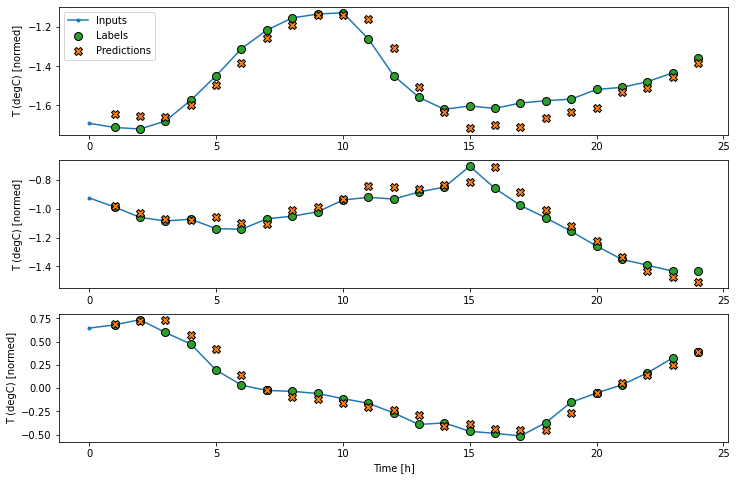

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

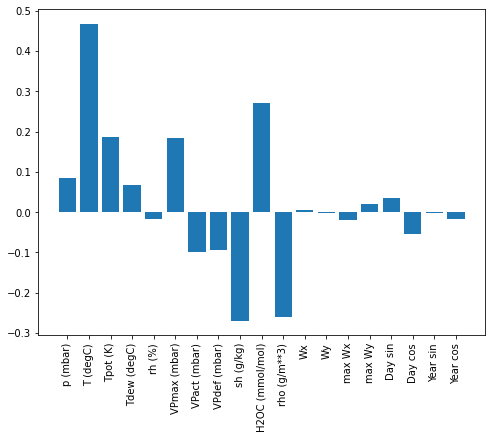

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 12:07 - loss: 1.7312 - mean_absolute_error: 1.0399

  17/1534 [..............................] - ETA: 4s - loss: 0.5485 - mean_absolute_error: 0.5264   

  34/1534 [..............................] - ETA: 4s - loss: 0.3164 - mean_absolute_error: 0.3771

  51/1534 [..............................] - ETA: 4s - loss: 0.2232 - mean_absolute_error: 0.3006

  68/1534 [>.............................] - ETA: 4s - loss: 0.1738 - mean_absolute_error: 0.2564

  85/1534 [>.............................] - ETA: 4s - loss: 0.1443 - mean_absolute_error: 0.2299

 102/1534 [>.............................] - ETA: 4s - loss: 0.1235 - mean_absolute_error: 0.2097

 119/1534 [=>............................] - ETA: 4s - loss: 0.1085 - mean_absolute_error: 0.1947

 136/1534 [=>............................] - ETA: 4s - loss: 0.0969 - mean_absolute_error: 0.1827

 153/1534 [=>............................] - ETA: 4s - loss: 0.0878 - mean_absolute_error: 0.1732

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0806 - mean_absolute_error: 0.1652

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0744 - mean_absolute_error: 0.1582

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0696 - mean_absolute_error: 0.1524

 221/1534 [===>..........................] - ETA: 3s - loss: 0.0652 - mean_absolute_error: 0.1472

 238/1534 [===>..........................] - ETA: 3s - loss: 0.0613 - mean_absolute_error: 0.1424

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0579 - mean_absolute_error: 0.1384

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0551 - mean_absolute_error: 0.1349

 288/1534 [====>.........................] - ETA: 3s - loss: 0.0527 - mean_absolute_error: 0.1323

 305/1534 [====>.........................] - ETA: 3s - loss: 0.0504 - mean_absolute_error: 0.1293

 322/1534 [=====>........................] - ETA: 3s - loss: 0.0483 - mean_absolute_error: 0.1265

 339/1534 [=====>........................] - ETA: 3s - loss: 0.0464 - mean_absolute_error: 0.1242

 356/1534 [=====>........................] - ETA: 3s - loss: 0.0447 - mean_absolute_error: 0.1220

 373/1534 [======>.......................] - ETA: 3s - loss: 0.0431 - mean_absolute_error: 0.1200

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0417 - mean_absolute_error: 0.1180

 406/1534 [======>.......................] - ETA: 3s - loss: 0.0403 - mean_absolute_error: 0.1162

 423/1534 [=======>......................] - ETA: 3s - loss: 0.0391 - mean_absolute_error: 0.1145

 440/1534 [=======>......................] - ETA: 3s - loss: 0.0380 - mean_absolute_error: 0.1130

 457/1534 [=======>......................] - ETA: 3s - loss: 0.0369 - mean_absolute_error: 0.1115

 474/1534 [========>.....................] - ETA: 3s - loss: 0.0359 - mean_absolute_error: 0.1101

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0350 - mean_absolute_error: 0.1087

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0342 - mean_absolute_error: 0.1076

 524/1534 [=========>....................] - ETA: 3s - loss: 0.0334 - mean_absolute_error: 0.1065

 541/1534 [=========>....................] - ETA: 3s - loss: 0.0326 - mean_absolute_error: 0.1054

 558/1534 [=========>....................] - ETA: 2s - loss: 0.0319 - mean_absolute_error: 0.1044

 575/1534 [==========>...................] - ETA: 2s - loss: 0.0312 - mean_absolute_error: 0.1034

 592/1534 [==========>...................] - ETA: 2s - loss: 0.0306 - mean_absolute_error: 0.1025

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0300 - mean_absolute_error: 0.1015

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0294 - mean_absolute_error: 0.1006

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0288 - mean_absolute_error: 0.0997

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0283 - mean_absolute_error: 0.0990

 676/1534 [============>.................] - ETA: 2s - loss: 0.0279 - mean_absolute_error: 0.0983

 693/1534 [============>.................] - ETA: 2s - loss: 0.0274 - mean_absolute_error: 0.0977

 711/1534 [============>.................] - ETA: 2s - loss: 0.0270 - mean_absolute_error: 0.0970

 728/1534 [=============>................] - ETA: 2s - loss: 0.0265 - mean_absolute_error: 0.0964

 745/1534 [=============>................] - ETA: 2s - loss: 0.0262 - mean_absolute_error: 0.0959

 762/1534 [=============>................] - ETA: 2s - loss: 0.0258 - mean_absolute_error: 0.0953

 779/1534 [==============>...............] - ETA: 2s - loss: 0.0254 - mean_absolute_error: 0.0947

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0251 - mean_absolute_error: 0.0943

 813/1534 [==============>...............] - ETA: 2s - loss: 0.0248 - mean_absolute_error: 0.0939

 830/1534 [===============>..............] - ETA: 2s - loss: 0.0245 - mean_absolute_error: 0.0936

 847/1534 [===============>..............] - ETA: 2s - loss: 0.0242 - mean_absolute_error: 0.0932

 864/1534 [===============>..............] - ETA: 2s - loss: 0.0239 - mean_absolute_error: 0.0927

 881/1534 [================>.............] - ETA: 1s - loss: 0.0236 - mean_absolute_error: 0.0923

 898/1534 [================>.............] - ETA: 1s - loss: 0.0234 - mean_absolute_error: 0.0919

 915/1534 [================>.............] - ETA: 1s - loss: 0.0231 - mean_absolute_error: 0.0914

 932/1534 [=================>............] - ETA: 1s - loss: 0.0228 - mean_absolute_error: 0.0910

 949/1534 [=================>............] - ETA: 1s - loss: 0.0226 - mean_absolute_error: 0.0907

 966/1534 [=================>............] - ETA: 1s - loss: 0.0223 - mean_absolute_error: 0.0903

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.0900

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0219 - mean_absolute_error: 0.0896

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.0893

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.0890

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0213 - mean_absolute_error: 0.0887

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.0885

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.0882

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.0879

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.0876

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.0875

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.0874

1169/1534 [=====================>........] - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.0871

1186/1534 [======================>.......] - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.0868

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0198 - mean_absolute_error: 0.0866

1220/1534 [======================>.......] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.0862

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0195 - mean_absolute_error: 0.0860

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.0857

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0192 - mean_absolute_error: 0.0855

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.0853

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0189 - mean_absolute_error: 0.0851

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0188 - mean_absolute_error: 0.0849

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0187 - mean_absolute_error: 0.0847

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.0844

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0184 - mean_absolute_error: 0.0842

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.0840

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0182 - mean_absolute_error: 0.0839

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.0837

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0180 - mean_absolute_error: 0.0835

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0178 - mean_absolute_error: 0.0833

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0177 - mean_absolute_error: 0.0831

1491/1534 [============================>.] - ETA: 0s - loss: 0.0176 - mean_absolute_error: 0.0830

1508/1534 [============================>.] - ETA: 0s - loss: 0.0175 - mean_absolute_error: 0.0828

1526/1534 [============================>.] - ETA: 0s - loss: 0.0174 - mean_absolute_error: 0.0826

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0174 - mean_absolute_error: 0.0826 - val_loss: 0.0078 - val_mean_absolute_error: 0.0640


Epoch 2/20
   1/1534 [..............................] - ETA: 32s - loss: 0.0100 - mean_absolute_error: 0.0636

  18/1534 [..............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0637 

  35/1534 [..............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0644

  52/1534 [>.............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0638

  69/1534 [>.............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0641

  86/1534 [>.............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0647

 103/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0646

 120/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0647

 136/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0644

 152/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0640

 168/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0643

 185/1534 [==>...........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0641

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0645

 218/1534 [===>..........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0645

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0643

 251/1534 [===>..........................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0642

 267/1534 [====>.........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0642

 283/1534 [====>.........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0647

 300/1534 [====>.........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0644

 317/1534 [=====>........................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0644

 333/1534 [=====>........................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0644

 349/1534 [=====>........................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0644

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0642

 383/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0641

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0639

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0637

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0637

 450/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0636

 467/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0636

 484/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0636

 501/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0636

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0636

 535/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0636

 552/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0635

 569/1534 [==========>...................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0636

 586/1534 [==========>...................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0636

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0636

 620/1534 [===========>..................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0635

 637/1534 [===========>..................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0634

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0635

 671/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0634

 687/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0634

 704/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0634

 721/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0633

 738/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0633

 754/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0634

 770/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0634

 787/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0634

 804/1534 [==============>...............] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0638

 821/1534 [===============>..............] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0638

 838/1534 [===============>..............] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0639

 855/1534 [===============>..............] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0639

 872/1534 [================>.............] - ETA: 2s - loss: 0.0077 - mean_absolute_error: 0.0639

 889/1534 [================>.............] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0639

 905/1534 [================>.............] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0640

 922/1534 [=================>............] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0639

 939/1534 [=================>............] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0640

 955/1534 [=================>............] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0639

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0639

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0639

1004/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0639

1020/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0639

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0639

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0639

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0639

1088/1534 [====================>.........] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0640

1105/1534 [====================>.........] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0640

1122/1534 [====================>.........] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0640

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0640

1156/1534 [=====================>........] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0642

1173/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0642

1190/1534 [======================>.......] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0642

1207/1534 [======================>.......] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0641

1223/1534 [======================>.......] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1239/1534 [=======================>......] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1403/1534 [==========================>...] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1486/1534 [============================>.] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0642

1503/1534 [============================>.] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0642

1519/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0643

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0643 - val_loss: 0.0079 - val_mean_absolute_error: 0.0656


Epoch 3/20
   1/1534 [..............................] - ETA: 35s - loss: 0.0113 - mean_absolute_error: 0.0803

  18/1534 [..............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0615 

  35/1534 [..............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0625

  52/1534 [>.............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0641

  69/1534 [>.............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0641

  86/1534 [>.............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0644

 103/1534 [=>............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0637

 120/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0636

 137/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0631

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0626

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0624

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0623

 206/1534 [===>..........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0630

 223/1534 [===>..........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0631

 240/1534 [===>..........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 257/1534 [====>.........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0629

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0631

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 325/1534 [=====>........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0629

 359/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0629

 376/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0626

 393/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0625

 410/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0624

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0623

 444/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0623

 460/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 477/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0620

 494/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 511/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0620

 528/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 545/1534 [=========>....................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0620

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0620

 579/1534 [==========>...................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0620

 596/1534 [==========>...................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0621

 613/1534 [==========>...................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0619

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0619

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0619

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0621

 680/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0622

 697/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0623

 713/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0622

 730/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0623

 747/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0623

 764/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0623

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0622

 797/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0622

 813/1534 [==============>...............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0624

 829/1534 [===============>..............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0625

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0626

 862/1534 [===============>..............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0626

 879/1534 [================>.............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0626

 896/1534 [================>.............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0626

 912/1534 [================>.............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0625

 929/1534 [=================>............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0625

 946/1534 [=================>............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0625

 963/1534 [=================>............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0626

 979/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0626

 996/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1062/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1112/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

1128/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1145/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0628

1161/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

1178/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0628

1195/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0627

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0627

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1430/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1497/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1514/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1532/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0625 - val_loss: 0.0072 - val_mean_absolute_error: 0.0615


Epoch 4/20
   1/1534 [..............................] - ETA: 32s - loss: 0.0045 - mean_absolute_error: 0.0567

  18/1534 [..............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0606 

  35/1534 [..............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0607

  52/1534 [>.............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0615

  69/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0612

  86/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0611

 103/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0610

 120/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0611

 137/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0606

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0609

 171/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0612

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0614

 205/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0615

 221/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0616

 238/1534 [===>..........................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0615

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0613

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0612

 289/1534 [====>.........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 306/1534 [====>.........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 323/1534 [=====>........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 340/1534 [=====>........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0612

 357/1534 [=====>........................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0614

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 391/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 408/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0616

 425/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0614

 442/1534 [=======>......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0613

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 476/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 492/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 509/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 526/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 542/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 558/1534 [=========>....................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0609

 575/1534 [==========>...................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0608

 592/1534 [==========>...................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0609

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0607

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0608

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 677/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 694/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 711/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 727/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 744/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 760/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 794/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0607

 811/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0608

 828/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0610

 845/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0610

 863/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0610

 880/1534 [================>.............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0611

 898/1534 [================>.............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

 916/1534 [================>.............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

 933/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

 950/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

 968/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0611

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0613

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0612

1140/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1156/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0614

1172/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0614

1189/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0614

1206/1534 [======================>.......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0614

1223/1534 [======================>.......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0613

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0613

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0613

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0612

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0613

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1340/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0614

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0613

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0614

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1492/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1509/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0614

1526/1534 [============================>.] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0614

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0614 - val_loss: 0.0073 - val_mean_absolute_error: 0.0631


Epoch 5/20
   1/1534 [..............................] - ETA: 33s - loss: 0.0041 - mean_absolute_error: 0.0471

  17/1534 [..............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0637 

  34/1534 [..............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0637

  51/1534 [..............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0617

  68/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0608

  85/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0601

 102/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0606

 119/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0607

 136/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0606

 153/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0602

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0602

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0603

 203/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0602

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0602

 237/1534 [===>..........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0599

 254/1534 [===>..........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 271/1534 [====>.........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 287/1534 [====>.........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0597

 304/1534 [====>.........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 320/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 336/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0598

 368/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0599

 384/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0598

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0597

 449/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 466/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 483/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 500/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 517/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 533/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 599/1534 [==========>...................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 616/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0590

 632/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 665/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 682/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 699/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 716/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 733/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0590

 750/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 766/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 783/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 800/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 816/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 833/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 850/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 866/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 883/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 900/1534 [================>.............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0593

 917/1534 [================>.............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0593

 934/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

 951/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

 968/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1069/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0596

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1169/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1185/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1201/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1216/1534 [======================>.......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0596

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0596

1403/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1471/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1488/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1505/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1522/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0598 - val_loss: 0.0068 - val_mean_absolute_error: 0.0584


Epoch 6/20
   1/1534 [..............................] - ETA: 32s - loss: 0.0063 - mean_absolute_error: 0.0613

  18/1534 [..............................] - ETA: 4s - loss: 0.0059 - mean_absolute_error: 0.0559 

  34/1534 [..............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0582

  51/1534 [..............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0589

  67/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0585

  83/1534 [>.............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0575

 100/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0579

 114/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 131/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0584

 148/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0583

 165/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 182/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0590

 199/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0589

 216/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0588

 233/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0588

 250/1534 [===>..........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 266/1534 [====>.........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0587

 283/1534 [====>.........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0588

 300/1534 [====>.........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 317/1534 [=====>........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0588

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 367/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 383/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 450/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 467/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 484/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 500/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 516/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 533/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 550/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 567/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0584

 584/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0584

 601/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0584

 618/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0584

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0581

 669/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 687/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 705/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 723/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 741/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 759/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 795/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 812/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0584

 829/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0585

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 863/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 879/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0587

 896/1534 [================>.............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 913/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0587

 930/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 947/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

 963/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1082/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0592

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1149/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1200/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1217/1534 [======================>.......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1234/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1499/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1515/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1533/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0593 - val_loss: 0.0079 - val_mean_absolute_error: 0.0645


Epoch 7/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0075 - mean_absolute_error: 0.0587

  18/1534 [..............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0626 

  36/1534 [..............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0622

  53/1534 [>.............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0621

  70/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0611

  87/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0604

 105/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0599

 122/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0593

 139/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0594

 157/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 175/1534 [==>...........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 211/1534 [===>..........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0592

 247/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0590

 265/1534 [====>.........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 283/1534 [====>.........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 301/1534 [====>.........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 335/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 352/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 369/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 403/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 421/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 490/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 526/1534 [=========>....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 544/1534 [=========>....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 580/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 598/1534 [==========>...................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 616/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 634/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 670/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 688/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 706/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 724/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 742/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 760/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 778/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0578

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 832/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 850/1534 [===============>..............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

 868/1534 [===============>..............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

 886/1534 [================>.............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0582

 904/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

 922/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0582

 939/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0583

 956/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0583

 974/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0583

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0583

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0586

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0586

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1081/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

1117/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

1153/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1170/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1188/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1206/1534 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1224/1534 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1242/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1490/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1508/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1526/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0070 - val_mean_absolute_error: 0.0602


  1/439 [..............................] - ETA: 22s - loss: 0.0071 - mean_absolute_error: 0.0632

 23/439 [>.............................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0619 

 46/439 [==>...........................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0602

 68/439 [===>..........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0585

 90/439 [=====>........................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0585

113/439 [======>.......................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0590

135/439 [========>.....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0593

157/439 [=========>....................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0598

180/439 [===========>..................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0598

203/439 [============>.................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0598

226/439 [==============>...............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0599

245/439 [===============>..............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

268/439 [=================>............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0602

290/439 [==================>...........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0603

313/439 [====================>.........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0602

335/439 [=====================>........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0603

358/439 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601

380/439 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601

402/439 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0602

425/439 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601

439/439 [==============================] - 1s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0602


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

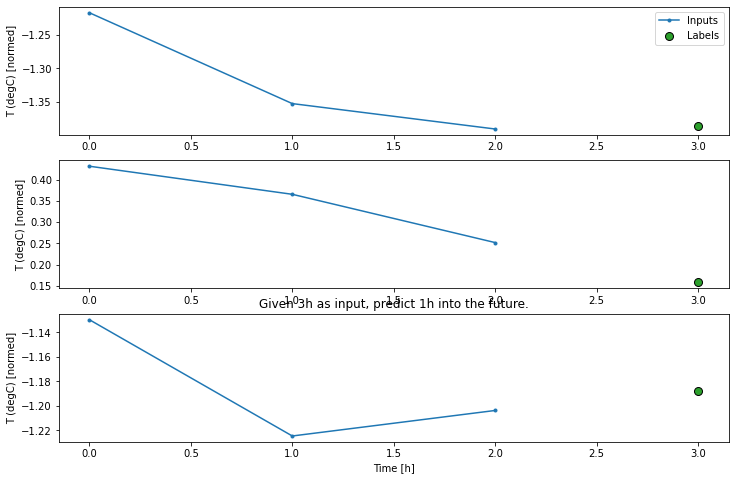

In [48]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 25s - loss: 0.0056 - mean_absolute_error: 0.0574

 29/438 [>.............................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0562 

 59/438 [===>..........................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0550

 89/438 [=====>........................] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0540

119/438 [=======>......................] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0541

150/438 [=========>....................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0549

180/438 [===========>..................] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0543

209/438 [=============>................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0548

239/438 [===============>..............] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0550

269/438 [=================>............] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0550

299/438 [===================>..........] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0549

328/438 [=====================>........] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0549

358/438 [=======================>......] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0547

387/438 [=========================>....] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0545

416/438 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0545

438/438 [==============================] - 1s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0546


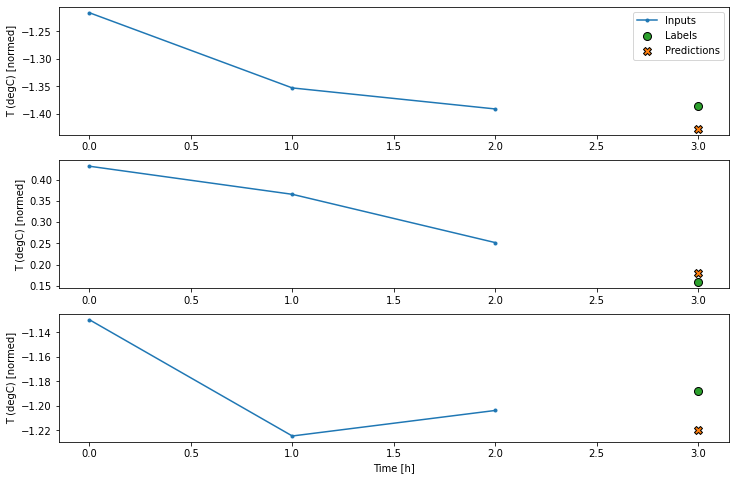

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 57 but received input with shape (32, 456)


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 26s - loss: 0.0075 - mean_absolute_error: 0.0623

 20/438 [>.............................] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0597 

 40/438 [=>............................] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0604

 60/438 [===>..........................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0602

 80/438 [====>.........................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0597

100/438 [=====>........................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

120/438 [=======>......................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0595

140/438 [========>.....................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0598

160/438 [=========>....................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

180/438 [===========>..................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

200/438 [============>.................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0601

221/438 [==============>...............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

241/438 [===============>..............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0601

261/438 [================>.............] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0604

281/438 [==================>...........] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

300/438 [===================>..........] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

321/438 [====================>.........] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

341/438 [======================>.......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0609

361/438 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0608

381/438 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

401/438 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

420/438 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

438/438 [==============================] - 1s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0611


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

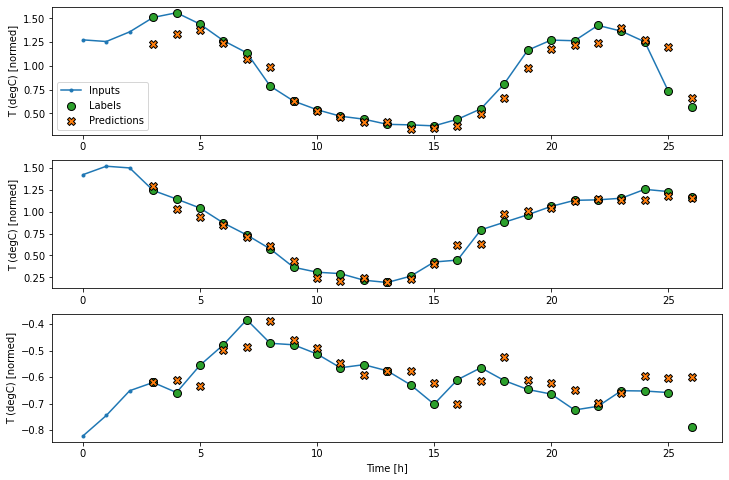

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](images/lstm_1_window.png)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 25s - loss: 0.0048 - mean_absolute_error: 0.0499

 19/438 [>.............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0513 

 39/438 [=>............................] - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.0520

 58/438 [==>...........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0516

 77/438 [====>.........................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0514

 96/438 [=====>........................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0518

115/438 [======>.......................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0517

134/438 [========>.....................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0517

153/438 [=========>....................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0517

172/438 [==========>...................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0517

191/438 [============>.................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

210/438 [=============>................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

229/438 [==============>...............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

248/438 [===============>..............] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0517

267/438 [=================>............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

286/438 [==================>...........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

305/438 [===================>..........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

324/438 [=====================>........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

343/438 [======================>.......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

362/438 [=======================>......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

381/438 [=========================>....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

400/438 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

419/438 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

438/438 [==============================] - 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0515


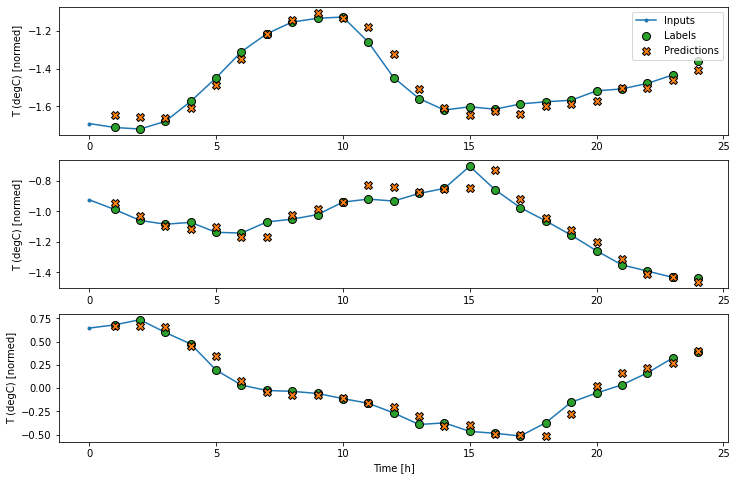

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it.

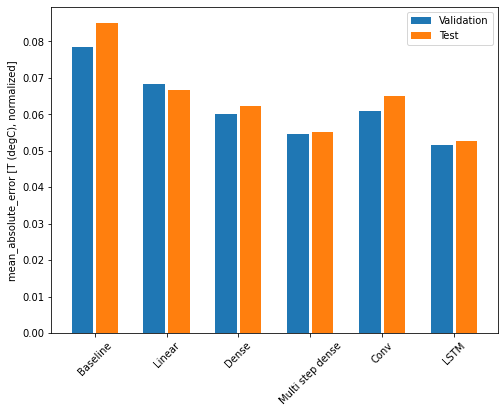

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0666
Dense       : 0.0623
Multi step dense: 0.0552
Conv        : 0.0650
LSTM        : 0.0527


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 44s - loss: 0.0821 - mean_absolute_error: 0.1556

 33/438 [=>............................] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1587 

 66/438 [===>..........................] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.1594

 97/438 [=====>........................] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1591

128/438 [=======>......................] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.1590

159/438 [=========>....................] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.1590

190/438 [============>.................] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.1590

222/438 [==============>...............] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.1589

253/438 [================>.............] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1590

284/438 [==================>...........] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1592

316/438 [====================>.........] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

348/438 [======================>.......] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1590

379/438 [========================>.....] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

410/438 [===========================>..] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.1589

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 24s - loss: 0.0513 - mean_absolute_error: 0.1157

 22/439 [>.............................] - ETA: 1s - loss: 0.0663 - mean_absolute_error: 0.1298 

 43/439 [=>............................] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1301

 64/439 [===>..........................] - ETA: 0s - loss: 0.0664 - mean_absolute_error: 0.1279

 85/439 [====>.........................] - ETA: 0s - loss: 0.0670 - mean_absolute_error: 0.1287

106/439 [======>.......................] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1292

127/439 [=======>......................] - ETA: 0s - loss: 0.0675 - mean_absolute_error: 0.1292

148/439 [=========>....................] - ETA: 0s - loss: 0.0673 - mean_absolute_error: 0.1290

169/439 [==========>...................] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1298

190/439 [===========>..................] - ETA: 0s - loss: 0.0675 - mean_absolute_error: 0.1294

211/439 [=============>................] - ETA: 0s - loss: 0.0671 - mean_absolute_error: 0.1293

232/439 [==============>...............] - ETA: 0s - loss: 0.0672 - mean_absolute_error: 0.1292

253/439 [================>.............] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.1296

274/439 [=================>............] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.1294

295/439 [===================>..........] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1297

316/439 [====================>.........] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1296

337/439 [======================>.......] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1296

358/439 [=======================>......] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.1295

379/439 [========================>.....] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.1292

399/439 [==========================>...] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1295

420/439 [===========================>..] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1295

439/439 [==============================] - 1s 2ms/step - loss: 0.0680 - mean_absolute_error: 0.1296


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 24s - loss: 0.0681 - mean_absolute_error: 0.1245

 20/438 [>.............................] - ETA: 1s - loss: 0.0634 - mean_absolute_error: 0.1224 

 40/438 [=>............................] - ETA: 1s - loss: 0.0639 - mean_absolute_error: 0.1233

 59/438 [===>..........................] - ETA: 1s - loss: 0.0625 - mean_absolute_error: 0.1217

 78/438 [====>.........................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1215

 97/438 [=====>........................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1214

116/438 [======>.......................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1214

135/438 [========>.....................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1212

154/438 [=========>....................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1209

173/438 [==========>...................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1210

191/438 [============>.................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1207

211/438 [=============>................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1207

230/438 [==============>...............] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1207

249/438 [================>.............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1206

267/438 [=================>............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1206

286/438 [==================>...........] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1205

305/438 [===================>..........] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1206

324/438 [=====================>........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1205

343/438 [======================>.......] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1204

362/438 [=======================>......] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1204

381/438 [=========================>....] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1204

400/438 [==========================>...] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1204

418/438 [===========================>..] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1204

438/438 [==============================] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1204

438/438 [==============================] - 1s 3ms/step - loss: 0.0615 - mean_absolute_error: 0.1204



CPU times: user 4min 32s, sys: 1min 2s, total: 5min 34s
Wall time: 1min 49s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 22s - loss: 0.0685 - mean_absolute_error: 0.1202

 20/438 [>.............................] - ETA: 1s - loss: 0.0629 - mean_absolute_error: 0.1183 

 39/438 [=>............................] - ETA: 1s - loss: 0.0621 - mean_absolute_error: 0.1176

 58/438 [==>...........................] - ETA: 1s - loss: 0.0621 - mean_absolute_error: 0.1179

 76/438 [====>.........................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1177

 94/438 [=====>........................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1175

112/438 [======>.......................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1176

130/438 [=======>......................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1179

149/438 [=========>....................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

167/438 [==========>...................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1176

186/438 [===========>..................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1177

205/438 [=============>................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1176

224/438 [==============>...............] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1175

243/438 [===============>..............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1176

262/438 [================>.............] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

281/438 [==================>...........] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

300/438 [===================>..........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

319/438 [====================>.........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

337/438 [======================>.......] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

356/438 [=======================>......] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

374/438 [========================>.....] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

393/438 [=========================>....] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

412/438 [===========================>..] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

429/438 [============================>.] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

438/438 [==============================] - 1s 3ms/step - loss: 0.0621 - mean_absolute_error: 0.1178



CPU times: user 2min, sys: 27.8 s, total: 2min 28s
Wall time: 49.1 s


#### Performance

Here is the overall performance for these multi-output models.

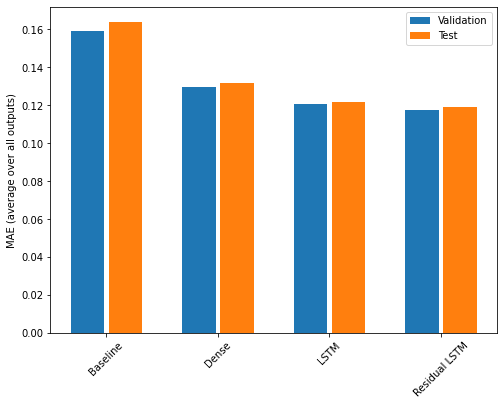

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1317
LSTM           : 0.1219
Residual LSTM  : 0.1189


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

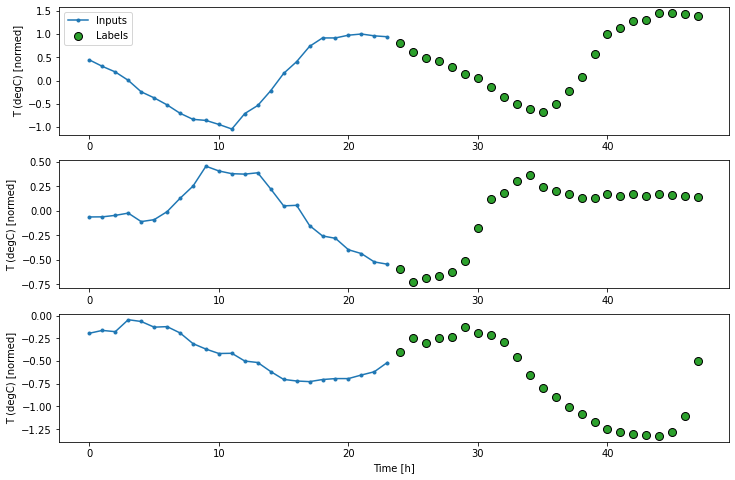

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 58s - loss: 0.5794 - mean_absolute_error: 0.4924

 33/437 [=>............................] - ETA: 0s - loss: 0.6523 - mean_absolute_error: 0.5106 

 65/437 [===>..........................] - ETA: 0s - loss: 0.6432 - mean_absolute_error: 0.5064

 96/437 [=====>........................] - ETA: 0s - loss: 0.6373 - mean_absolute_error: 0.5043

128/437 [=======>......................] - ETA: 0s - loss: 0.6330 - mean_absolute_error: 0.5030

160/437 [=========>....................] - ETA: 0s - loss: 0.6314 - mean_absolute_error: 0.5024

191/437 [============>.................] - ETA: 0s - loss: 0.6323 - mean_absolute_error: 0.5027

222/437 [==============>...............] - ETA: 0s - loss: 0.6317 - mean_absolute_error: 0.5024

253/437 [================>.............] - ETA: 0s - loss: 0.6292 - mean_absolute_error: 0.5010

285/437 [==================>...........] - ETA: 0s - loss: 0.6284 - mean_absolute_error: 0.5008

316/437 [====================>.........] - ETA: 0s - loss: 0.6291 - mean_absolute_error: 0.5009

348/437 [======================>.......] - ETA: 0s - loss: 0.6288 - mean_absolute_error: 0.5007

380/437 [=========================>....] - ETA: 0s - loss: 0.6284 - mean_absolute_error: 0.5006

412/437 [===========================>..] - ETA: 0s - loss: 0.6292 - mean_absolute_error: 0.5009

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


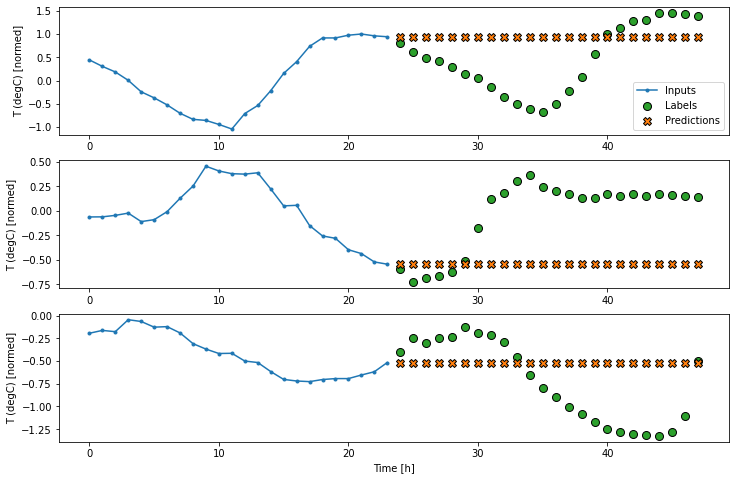

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 52s - loss: 0.5448 - mean_absolute_error: 0.4464

 32/437 [=>............................] - ETA: 0s - loss: 0.4282 - mean_absolute_error: 0.3954 

 65/437 [===>..........................] - ETA: 0s - loss: 0.4215 - mean_absolute_error: 0.3929

 97/437 [=====>........................] - ETA: 0s - loss: 0.4233 - mean_absolute_error: 0.3940

129/437 [=======>......................] - ETA: 0s - loss: 0.4239 - mean_absolute_error: 0.3941

161/437 [==========>...................] - ETA: 0s - loss: 0.4215 - mean_absolute_error: 0.3931

192/437 [============>.................] - ETA: 0s - loss: 0.4228 - mean_absolute_error: 0.3940

222/437 [==============>...............] - ETA: 0s - loss: 0.4213 - mean_absolute_error: 0.3934

253/437 [================>.............] - ETA: 0s - loss: 0.4228 - mean_absolute_error: 0.3941

283/437 [==================>...........] - ETA: 0s - loss: 0.4219 - mean_absolute_error: 0.3937

315/437 [====================>.........] - ETA: 0s - loss: 0.4227 - mean_absolute_error: 0.3940

347/437 [======================>.......] - ETA: 0s - loss: 0.4242 - mean_absolute_error: 0.3946

379/437 [=========================>....] - ETA: 0s - loss: 0.4252 - mean_absolute_error: 0.3950

410/437 [===========================>..] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.3959

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


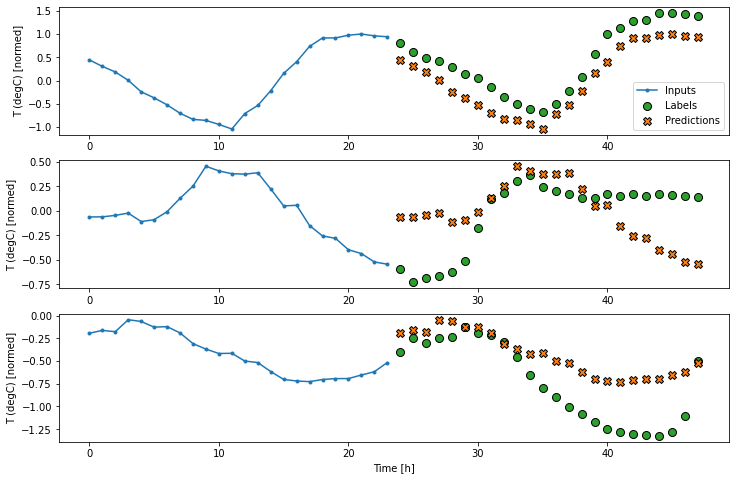

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 21s - loss: 0.2021 - mean_absolute_error: 0.2702

 27/437 [>.............................] - ETA: 0s - loss: 0.2608 - mean_absolute_error: 0.3062 

 54/437 [==>...........................] - ETA: 0s - loss: 0.2604 - mean_absolute_error: 0.3066

 81/437 [====>.........................] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3050

108/437 [======>.......................] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3054

135/437 [========>.....................] - ETA: 0s - loss: 0.2584 - mean_absolute_error: 0.3067

162/437 [==========>...................] - ETA: 0s - loss: 0.2601 - mean_absolute_error: 0.3076

190/437 [============>.................] - ETA: 0s - loss: 0.2588 - mean_absolute_error: 0.3070

217/437 [=============>................] - ETA: 0s - loss: 0.2580 - mean_absolute_error: 0.3063

242/437 [===============>..............] - ETA: 0s - loss: 0.2570 - mean_absolute_error: 0.3060

269/437 [=================>............] - ETA: 0s - loss: 0.2561 - mean_absolute_error: 0.3056

297/437 [===================>..........] - ETA: 0s - loss: 0.2576 - mean_absolute_error: 0.3063

323/437 [=====================>........] - ETA: 0s - loss: 0.2570 - mean_absolute_error: 0.3062

349/437 [======================>.......] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3058

375/437 [========================>.....] - ETA: 0s - loss: 0.2555 - mean_absolute_error: 0.3054

402/437 [==========================>...] - ETA: 0s - loss: 0.2554 - mean_absolute_error: 0.3055

429/437 [============================>.] - ETA: 0s - loss: 0.2553 - mean_absolute_error: 0.3054

437/437 [==============================] - 1s 2ms/step - loss: 0.2552 - mean_absolute_error: 0.3054


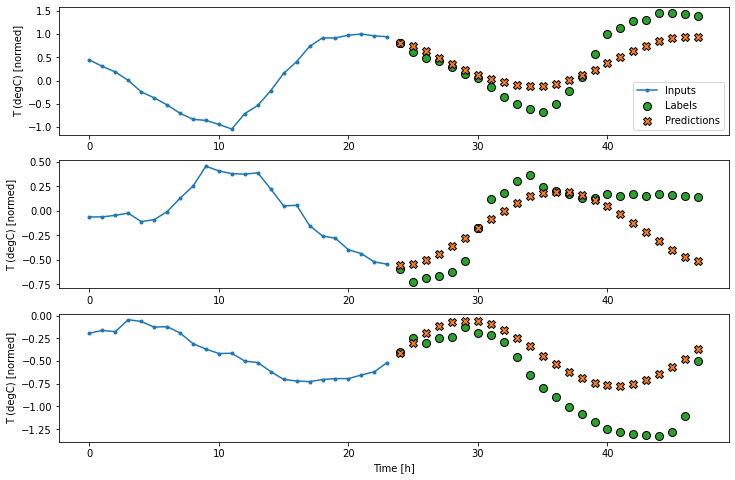

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

  1/437 [..............................] - ETA: 22s - loss: 0.2022 - mean_absolute_error: 0.2845

 22/437 [>.............................] - ETA: 1s - loss: 0.2256 - mean_absolute_error: 0.2848 

 44/437 [==>...........................] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2814

 65/437 [===>..........................] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2810

 86/437 [====>.........................] - ETA: 0s - loss: 0.2188 - mean_absolute_error: 0.2814

109/437 [======>.......................] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2811

131/437 [=======>......................] - ETA: 0s - loss: 0.2193 - mean_absolute_error: 0.2813

154/437 [=========>....................] - ETA: 0s - loss: 0.2204 - mean_absolute_error: 0.2820

176/437 [===========>..................] - ETA: 0s - loss: 0.2210 - mean_absolute_error: 0.2823

198/437 [============>.................] - ETA: 0s - loss: 0.2217 - mean_absolute_error: 0.2827

221/437 [==============>...............] - ETA: 0s - loss: 0.2223 - mean_absolute_error: 0.2829

243/437 [===============>..............] - ETA: 0s - loss: 0.2229 - mean_absolute_error: 0.2832

265/437 [=================>............] - ETA: 0s - loss: 0.2233 - mean_absolute_error: 0.2833

287/437 [==================>...........] - ETA: 0s - loss: 0.2231 - mean_absolute_error: 0.2831

308/437 [====================>.........] - ETA: 0s - loss: 0.2222 - mean_absolute_error: 0.2826

330/437 [=====================>........] - ETA: 0s - loss: 0.2219 - mean_absolute_error: 0.2825

352/437 [=======================>......] - ETA: 0s - loss: 0.2214 - mean_absolute_error: 0.2822

374/437 [========================>.....] - ETA: 0s - loss: 0.2212 - mean_absolute_error: 0.2822

396/437 [==========================>...] - ETA: 0s - loss: 0.2209 - mean_absolute_error: 0.2819

417/437 [===========================>..] - ETA: 0s - loss: 0.2205 - mean_absolute_error: 0.2816

437/437 [==============================] - 1s 2ms/step - loss: 0.2199 - mean_absolute_error: 0.2813


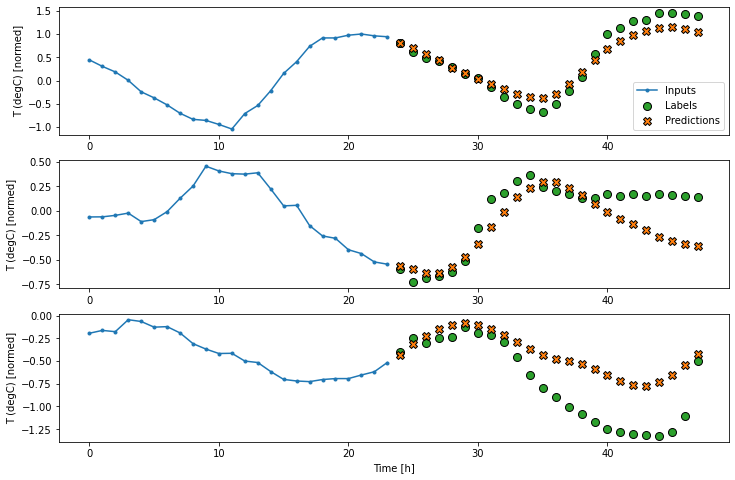

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 23s - loss: 0.2243 - mean_absolute_error: 0.2797

 23/437 [>.............................] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2804 

 46/437 [==>...........................] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2817

 70/437 [===>..........................] - ETA: 0s - loss: 0.2195 - mean_absolute_error: 0.2827

 93/437 [=====>........................] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2814

116/437 [======>.......................] - ETA: 0s - loss: 0.2165 - mean_absolute_error: 0.2811

140/437 [========>.....................] - ETA: 0s - loss: 0.2158 - mean_absolute_error: 0.2806

163/437 [==========>...................] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2811

186/437 [===========>..................] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2817

210/437 [=============>................] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2810

233/437 [==============>...............] - ETA: 0s - loss: 0.2161 - mean_absolute_error: 0.2811

256/437 [================>.............] - ETA: 0s - loss: 0.2155 - mean_absolute_error: 0.2807

279/437 [==================>...........] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2810

301/437 [===================>..........] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2811

324/437 [=====================>........] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2812

346/437 [======================>.......] - ETA: 0s - loss: 0.2153 - mean_absolute_error: 0.2811

369/437 [========================>.....] - ETA: 0s - loss: 0.2158 - mean_absolute_error: 0.2814

392/437 [=========================>....] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2814

415/437 [===========================>..] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2813

437/437 [==============================] - 1s 2ms/step - loss: 0.2162 - mean_absolute_error: 0.2817


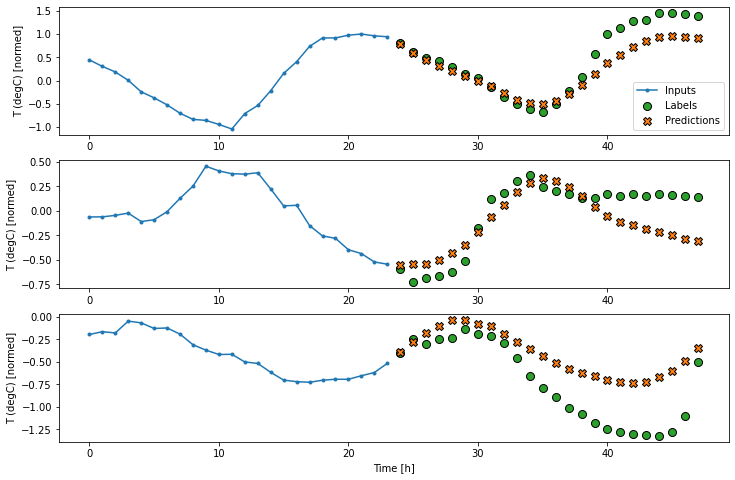

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 23s - loss: 0.2056 - mean_absolute_error: 0.2783

 21/437 [>.............................] - ETA: 1s - loss: 0.2233 - mean_absolute_error: 0.2897 

 42/437 [=>............................] - ETA: 0s - loss: 0.2122 - mean_absolute_error: 0.2835

 63/437 [===>..........................] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2840

 84/437 [====>.........................] - ETA: 0s - loss: 0.2123 - mean_absolute_error: 0.2834

105/437 [======>.......................] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2838

126/437 [=======>......................] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2843

147/437 [=========>....................] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2849

168/437 [==========>...................] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2845

189/437 [===========>..................] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2849

210/437 [=============>................] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2845

231/437 [==============>...............] - ETA: 0s - loss: 0.2130 - mean_absolute_error: 0.2841

252/437 [================>.............] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2845

273/437 [=================>............] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2846

294/437 [===================>..........] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2842

315/437 [====================>.........] - ETA: 0s - loss: 0.2131 - mean_absolute_error: 0.2841

336/437 [======================>.......] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2842

356/437 [=======================>......] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2843

377/437 [========================>.....] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2847

398/437 [==========================>...] - ETA: 0s - loss: 0.2148 - mean_absolute_error: 0.2848

419/437 [===========================>..] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2845

437/437 [==============================] - 1s 2ms/step - loss: 0.2141 - mean_absolute_error: 0.2844


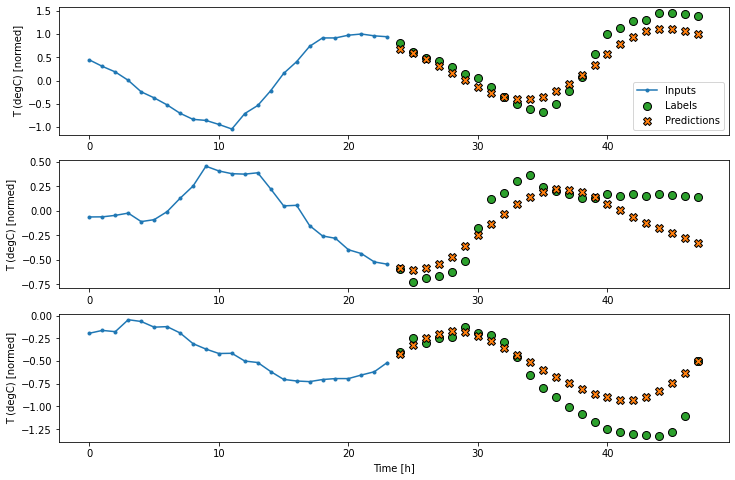

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)


#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step `LSTM` models: An `LSTM` followed by a `layers.Dense` that converts the `LSTM` outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach to collecting the output predictions is to use a python list, and `tf.stack` after the loop.

Note: Stacking a python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length you would need to use a `tf.TensorArray` instead of a python list, and `tf.range` instead of the python `range`.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now train the model:

  1/437 [..............................] - ETA: 24s - loss: 0.2079 - mean_absolute_error: 0.2991

  9/437 [..............................] - ETA: 2s - loss: 0.2272 - mean_absolute_error: 0.3029 

 17/437 [>.............................] - ETA: 2s - loss: 0.2289 - mean_absolute_error: 0.3029

 25/437 [>.............................] - ETA: 2s - loss: 0.2190 - mean_absolute_error: 0.2973

 33/437 [=>............................] - ETA: 2s - loss: 0.2201 - mean_absolute_error: 0.2972

 41/437 [=>............................] - ETA: 2s - loss: 0.2223 - mean_absolute_error: 0.2982

 49/437 [==>...........................] - ETA: 2s - loss: 0.2227 - mean_absolute_error: 0.2978

 57/437 [==>...........................] - ETA: 2s - loss: 0.2240 - mean_absolute_error: 0.2987

 65/437 [===>..........................] - ETA: 2s - loss: 0.2256 - mean_absolute_error: 0.2992

 73/437 [====>.........................] - ETA: 2s - loss: 0.2234 - mean_absolute_error: 0.2983

 81/437 [====>.........................] - ETA: 2s - loss: 0.2233 - mean_absolute_error: 0.2985

 89/437 [=====>........................] - ETA: 2s - loss: 0.2235 - mean_absolute_error: 0.2985

 97/437 [=====>........................] - ETA: 2s - loss: 0.2251 - mean_absolute_error: 0.2992

105/437 [======>.......................] - ETA: 2s - loss: 0.2263 - mean_absolute_error: 0.3001

113/437 [======>.......................] - ETA: 2s - loss: 0.2268 - mean_absolute_error: 0.3004

121/437 [=======>......................] - ETA: 2s - loss: 0.2271 - mean_absolute_error: 0.3008

129/437 [=======>......................] - ETA: 2s - loss: 0.2275 - mean_absolute_error: 0.3009

137/437 [========>.....................] - ETA: 2s - loss: 0.2273 - mean_absolute_error: 0.3008

145/437 [========>.....................] - ETA: 2s - loss: 0.2271 - mean_absolute_error: 0.3005

153/437 [=========>....................] - ETA: 1s - loss: 0.2263 - mean_absolute_error: 0.3001

161/437 [==========>...................] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.3000

169/437 [==========>...................] - ETA: 1s - loss: 0.2262 - mean_absolute_error: 0.3000

177/437 [===========>..................] - ETA: 1s - loss: 0.2267 - mean_absolute_error: 0.3002

185/437 [===========>..................] - ETA: 1s - loss: 0.2263 - mean_absolute_error: 0.3000

193/437 [============>.................] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.2996

201/437 [============>.................] - ETA: 1s - loss: 0.2257 - mean_absolute_error: 0.2996

209/437 [=============>................] - ETA: 1s - loss: 0.2256 - mean_absolute_error: 0.2996

217/437 [=============>................] - ETA: 1s - loss: 0.2255 - mean_absolute_error: 0.2996

225/437 [==============>...............] - ETA: 1s - loss: 0.2253 - mean_absolute_error: 0.2996

233/437 [==============>...............] - ETA: 1s - loss: 0.2251 - mean_absolute_error: 0.2996

241/437 [===============>..............] - ETA: 1s - loss: 0.2253 - mean_absolute_error: 0.2995

249/437 [================>.............] - ETA: 1s - loss: 0.2255 - mean_absolute_error: 0.2996

257/437 [================>.............] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.2996

265/437 [=================>............] - ETA: 1s - loss: 0.2260 - mean_absolute_error: 0.2997

273/437 [=================>............] - ETA: 1s - loss: 0.2266 - mean_absolute_error: 0.3001

281/437 [==================>...........] - ETA: 1s - loss: 0.2273 - mean_absolute_error: 0.3005

289/437 [==================>...........] - ETA: 1s - loss: 0.2268 - mean_absolute_error: 0.3002

297/437 [===================>..........] - ETA: 0s - loss: 0.2270 - mean_absolute_error: 0.3003

305/437 [===================>..........] - ETA: 0s - loss: 0.2264 - mean_absolute_error: 0.2999

313/437 [====================>.........] - ETA: 0s - loss: 0.2262 - mean_absolute_error: 0.2998

321/437 [=====================>........] - ETA: 0s - loss: 0.2264 - mean_absolute_error: 0.3000

329/437 [=====================>........] - ETA: 0s - loss: 0.2266 - mean_absolute_error: 0.3000

337/437 [======================>.......] - ETA: 0s - loss: 0.2268 - mean_absolute_error: 0.3001

345/437 [======================>.......] - ETA: 0s - loss: 0.2269 - mean_absolute_error: 0.3001

353/437 [=======================>......] - ETA: 0s - loss: 0.2271 - mean_absolute_error: 0.3003

361/437 [=======================>......] - ETA: 0s - loss: 0.2273 - mean_absolute_error: 0.3003

369/437 [========================>.....] - ETA: 0s - loss: 0.2272 - mean_absolute_error: 0.3002

377/437 [========================>.....] - ETA: 0s - loss: 0.2279 - mean_absolute_error: 0.3007

385/437 [=========================>....] - ETA: 0s - loss: 0.2278 - mean_absolute_error: 0.3006

393/437 [=========================>....] - ETA: 0s - loss: 0.2282 - mean_absolute_error: 0.3008

401/437 [==========================>...] - ETA: 0s - loss: 0.2276 - mean_absolute_error: 0.3005

409/437 [===========================>..] - ETA: 0s - loss: 0.2277 - mean_absolute_error: 0.3006

417/437 [===========================>..] - ETA: 0s - loss: 0.2276 - mean_absolute_error: 0.3006

425/437 [============================>.] - ETA: 0s - loss: 0.2274 - mean_absolute_error: 0.3005

433/437 [============================>.] - ETA: 0s - loss: 0.2274 - mean_absolute_error: 0.3005

437/437 [==============================] - 3s 7ms/step - loss: 0.2274 - mean_absolute_error: 0.3005


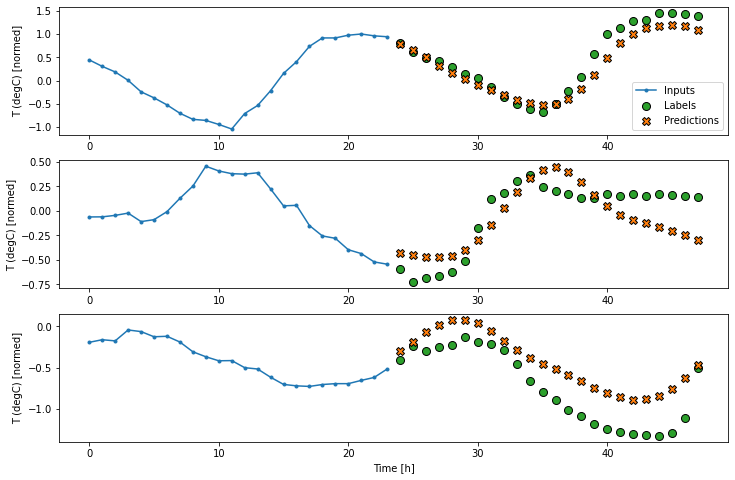

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

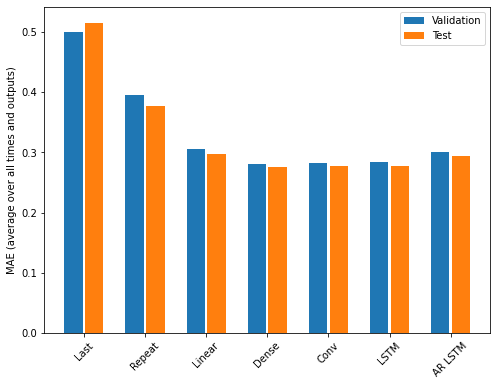

In [91]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2980
Dense   : 0.2751
Conv    : 0.2769
LSTM    : 0.2768
AR LSTM : 0.2936


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

* For further understanding, see:
  * Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition 
  * Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).
  * Lesson 8 of [Udacity's intro to TensorFlow for deep learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187), and the [exercise notebooks](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning) 
* Also remember that you can implement any [classical time series model](https://otexts.com/fpp2/index.html) in TensorFlow, this tutorial just focuses on TensorFlow's built-in functionality.